In [1]:
# ===============================================================================================================#
# Copyright 2021 Infosys Ltd.                                                                                    #
# Use of this source code is governed by Apache License Version 2.0 that can be found in the LICENSE file or at  #
# http://www.apache.org/licenses/                                                                                #
# ===============================================================================================================#

## 1. Preparation

In [2]:
import json
from libraries._internal_utils.demo_helper import DemoHelper
import pandas as pd
from IPython.display import Image

#### <span style='color:blue'>Add Tesseract to PATH environment variable</span>

In [3]:
# Add Tesseract to environment path if not set
import os

if (not len([x for x in os.environ['PATH'].split(';') if x.lower().find('tesseract') !=-1 ])):
    TESSERACT_HOME = os.environ['TESSERACT_HOME']
    os.environ['PATH']+=f";{TESSERACT_HOME}"
    print(f"Added tesseract path '{TESSERACT_HOME}' to environment path")

Added tesseract path 'C:\\Program Files\\Tesseract-OCR' to environment path


#### <span style='color:blue'>Enter image paths</span>

In [4]:
IMAGE_PATH='./data/sample_01.jpg'
TEMP_FOLDER_PATH = './data/temp'

#### Visualize

In [5]:
IMAGE_PATHS=[IMAGE_PATH]
tab_widget = DemoHelper.create_tab_toolbar(IMAGE_PATHS)
display(tab_widget)
for idx, image_path in enumerate(IMAGE_PATHS):
    with tab_widget.children[idx]:
        display(Image(filename=image_path, width=1000, height=50)) 

## 2. Initialization

#### <span style='color:blue'>Create new instance</span>

In [6]:
import logging
import os
from infy_bordered_table_extractor import bordered_table_extractor
from infy_bordered_table_extractor.providers.tesseract_data_service_provider import TesseractDataServiceProvider
from infy_bordered_table_extractor.bordered_table_extractor import LineDetectionMethod
from infy_bordered_table_extractor.bordered_table_extractor import OutputFileFormat

if not os.path.exists(TEMP_FOLDER_PATH):
    os.makedirs(TEMP_FOLDER_PATH)

if not os.path.exists('./logs'):
    os.makedirs('./logs')
logging.basicConfig(level=logging.CRITICAL, format='%(asctime)s.%(msecs)03d %(levelname)s'
                                ' ainauto-tabula - %(module)s - %(funcName)s: %(message)s')
logger = logging.getLogger()

provider = TesseractDataServiceProvider(None,logger=logger, log_level=logging.CRITICAL)

obj = bordered_table_extractor.BorderedTableExtractor(
        table_detection_provider = provider,
        cell_extraction_provider = provider,
        temp_folderpath = TEMP_FOLDER_PATH,
        logger=logger)

#### <span style='color:blue'>Enter Within Bounding Box Coordinates</span>

In [7]:
# Format = [x,y,w,h]
my_within_bbox = [75, 247, 1933, 282]

#### Visualize

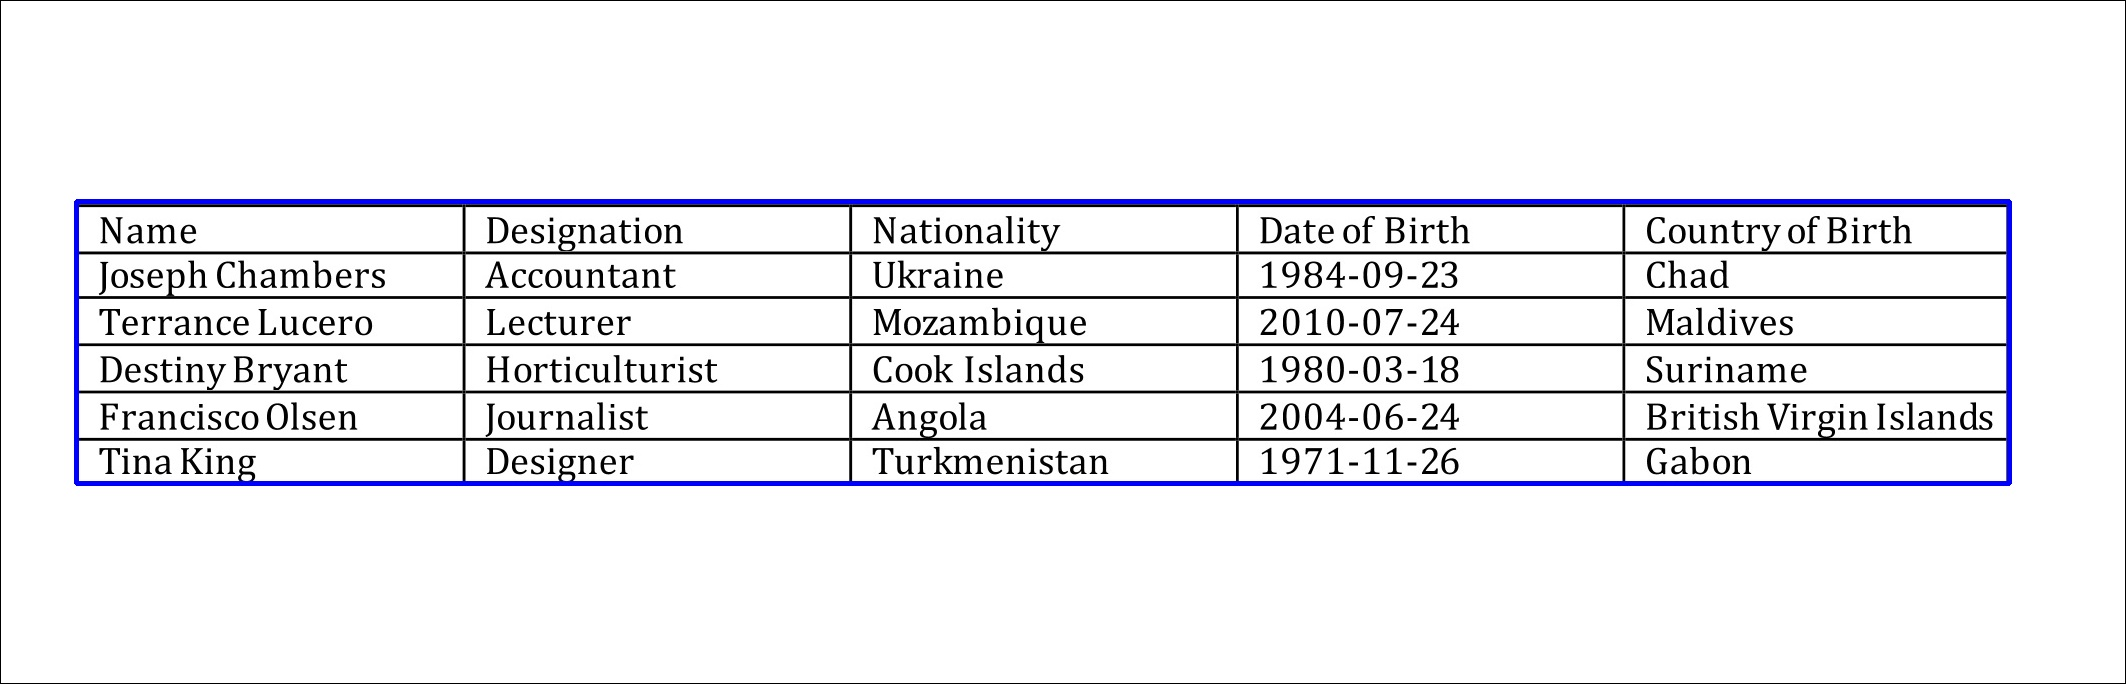

In [8]:
img = DemoHelper.read_image(IMAGE_PATH)
img = DemoHelper.draw_bboxes_on_image(img, [my_within_bbox], border_thickness=4,
                                         border_color = DemoHelper.Constants.COLOR_BLUE)
img = DemoHelper.reduce_image_based_on_context(img, [my_within_bbox])

DemoHelper.show_image(img)

## 3. API - extract_all_fields()

### 3.1 Example - To extract all cells using `RGB_LINE_DETECT` method and auto-detect header names
Default line detection method is `RGB_LINE_DETECT` 

With the help of `values` key, custom names can be provided to the header row or else it automatically names the 
column 'col_1', 'col_2' ...

In [9]:
config_param_dict = {
    'col_header': {
        'use_first_row': True,
        'values': []
    },
    'line_detection_method': [LineDetectionMethod.RGB_LINE_DETECT]
}

result_1 = obj.extract_all_fields(
    image_file=IMAGE_PATH,
    within_bbox = my_within_bbox,
    config_param_dict = config_param_dict)

#### Output

In [10]:
# print(json.dumps(result_1, indent=4))
df = pd.json_normalize(result_1['fields'][0]['table_value'])
# Postprocessing to remove newline chars
df.columns = df.columns.str.replace(r'\n','', regex=True)
df = df.replace(r'\n','', regex=True)

print('No. of records found =', len(df))
df.index = df.index + 1
df

No. of records found = 5


,Name,Designation,Nationality,Date of Birth,Country of Birth
1,Joseph Chambers,Accountant,Ukraine,1984-09-23,Chad
2,Terrance Lucero,Lecturer,Mozambique,2010-07-24,Maldives
3,Destiny Bryant,Horticulturist,Cook Islands,1980-03-18,Suriname
4,Francisco Olsen,Journalist,Angola,2004-06-24,British Virgin Islands
5,Tina King,Designer,Turkmenistan,1971-11-26,Gabon


### 3.2 Example - To extract all cells using `OPENCV_LINE_DETECT` method and save as an excel file

In [11]:
save_folder_path = './data'
config_param_dict = {
        'col_header': {
            'use_first_row': True,
        },
        'output': {
            'path': save_folder_path,
            'format': [OutputFileFormat.EXCEL]
        },
        'line_detection_method': [LineDetectionMethod.OPENCV_LINE_DETECT]
    }

result_2 = obj.extract_all_fields(image_file=IMAGE_PATH,
                                  within_bbox = my_within_bbox,
                                  config_param_dict = config_param_dict)

***Note: The output of the extracted table above using two different methods `RGB_LINE_DETECT` and `OPENCV_LINE_DETECT` are different depending on the type of image. Hence, the selection of the line detection method plays a major role here.***

#### Output

In [12]:
# print(json.dumps(result_2, indent=4))
df = pd.json_normalize(result_2['fields'][0]['table_value'])
# Postprocessing to remove newline chars
df.columns = df.columns.str.replace(r'\n','', regex=True)
df = df.replace(r'\n','', regex=True)

print('No. of records found =', len(df))
df.index = df.index + 1
df

No. of records found = 5


,Name,Designation,Nationality,Date of Birth,Country of Birth
1,Joseph Chambers,Accountant,Ukraine,1984-09-23,Chad
2,Terrance Lucero,Lecturer,Mozambique,2010-07-24,Maldives
3,Destiny Bryant,Horticulturist,Cook Islands,1980-03-18,Suriname
4,Francisco Olsen,Journalist,Angola,2004-06-24,British Virgin Islands
5,Tina King,Designer,Turkmenistan,1971-11-26,Gabon


### 3.3 Example - To extract custom cells

In [13]:
config_param_dict = {
    "custom_cells": [
        {
            "rows": ["2:4"],
            "columns":[1]
        },
        {
            "rows": ["5"],
            "columns":[2]
        }
    ]
}

result_3 = obj.extract_all_fields(image_file=IMAGE_PATH, 
                                  within_bbox = my_within_bbox,
                                  config_param_dict =config_param_dict)

#### Output

In [14]:
# print(json.dumps(result_3, indent=4))
df = pd.json_normalize(result_3['fields'][0]['table_value'])
# Postprocessing to remove newline chars
df.columns = df.columns.str.replace(r'\n','', regex=True)
df = df.replace(r'\n','', regex=True)

print('No. of records found =', len(df))
df.index = df.index + 1
df

No. of records found = 3


,__rownum,Designation,Nationality
1,2,Lecturer,((Not Extracted))
2,3,Horticulturist,((Not Extracted))
3,5,((Not Extracted)),Turkmenistan
